# <b>Introduction to Statistical Learning, 2nd Edition</b>
## by James, Witten, Hastie, Tibshirani

### Notes by Melis Tekant

## Chapter 4  - Classification 

What if the response variable is qualitative? In this case, we might want to perform classification of response, instead of quantitative regression. Some widely used classifiers are logistic regression, linear discriminant analysis, quadratic discriminant analysis, naive Bayes, and KNN. More complex and computer-intensive classification methods will be discussed in later chapters (Chs 7,8,9). 

In [1]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import norm

In [3]:
default = pd.read_csv('/Users/melistekant/Documents/Python Projects/ISLR2/Default.csv')
default.head()


,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


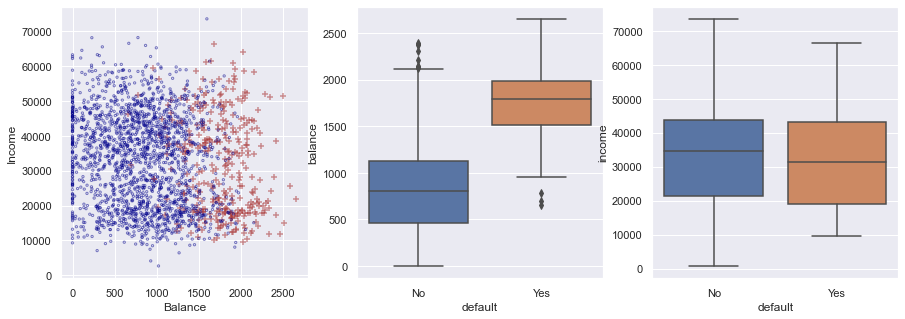

In [93]:
fig,axs = plt.subplots(1,3,figsize = (15,5))
defaulted = default[default['default']=='Yes']
notdef = default[default['default']=='No']
plt.subplot(1,3,1)
plt.scatter(defaulted['balance'],defaulted['income'],marker ='+',color='brown',alpha=0.5)
plt.scatter(notdef['balance'][::5],notdef['income'][::5],facecolor='None',edgecolor='darkblue',alpha=0.5,s=5)
plt.xlabel('Balance')
plt.ylabel('Income');

plt.subplot(1,3,2)
sns.boxplot(x='default',y='balance',data=default)
sns.set(rc = {'figure.figsize':(5,5)})

plt.subplot(1,3,3)
sns.boxplot(x='default',y='income',data=default)
sns.set(rc = {'figure.figsize':(5,5)})


#### Logistic regression:

Logistic regression models the probabiliy that Y belongs to a certain category. For the above data, this would be P(default = 'Yes' | balance) = p(balance). Although the prediction default = Yes will be made for p(balance) >0.5, for certain uses (say giving out a loan), a lower threshold can be chosen, e.g. p(balance) >0.1.

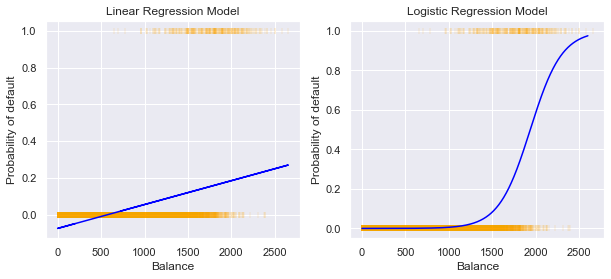

In [157]:
from sklearn.linear_model import LinearRegression
yndict = {'Yes':1,'No':0}
regress = LinearRegression()
X = default[['balance']]
y = default[['default']].applymap(lambda x: yndict[x])
regress = LinearRegression()
regress.fit(X,y)
y_pred = regress.predict(X)

plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X,y,marker='|',c='orange',alpha=0.1)
plt.plot(X,y_pred,color = 'blue')
plt.xlabel('Balance')
plt.ylabel('Probability of default')
plt.title('Linear Regression Model')

from sklearn.linear_model import LogisticRegression

xlin = np.linspace(0,2600,1000)
logreg = LogisticRegression(random_state=0)
logreg.fit(X,np.ravel(y))
y_predlog = logreg.predict_proba(xlin[:,np.newaxis])

plt.subplot(1,2,2)
plt.scatter(X,y,marker='|',c='orange',alpha=0.1)
plt.plot(xlin,y_predlog[:,1],color = 'blue')
plt.xlabel('Balance')
plt.ylabel('Probability of default')
plt.title('Logistic Regression Model');

Logistic regression model has output that can take on values between 0 and 1 for all input values. The function used is:

$$ p(X) = \frac{e^{\beta_0 +\beta_1 X}}{1+e^{\beta_0 + \beta_1X}}$$

this method can be used when the output ranges between two decisions for all input values. The quantity $ \frac{p(X)}{1-p(X)} = e^{\beta_0 +\beta_1 X}$ is called odds, in the range $[0,\infty]$. 0/$\infty$ indicates very low/high probability of default. 

Log odds, or logit is attained by taking the log of the odds.

$$ \log{\frac{p(X)}{1-p(X)}} = \beta_0 +\beta_1 X $$

and is linear in X. Increasing X by one unit corresponds to a change in log odds by $\beta_1$. 

The coefficients $\beta_0, \beta_1$ are unknown and need to be estimated from the training data. Least squares can be used but maximum likelihood is generally prefered due to its favorable statistical properties. The likelihood function is 

$$ l(\beta_0,\beta_1) = \prod_{i:y_i=1} p(x_i) \prod_{i':y_{i'}=0} (1-p(x_{i'})) $$

and the esimates of the coefficients are made such that they maximize the likelihood function $l$. 

For the above example,
